In [18]:
import matplotlib.pyplot as plt
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split

from processing.preprocessing import BCIDataProcessor

recording_path = '../recordings/recording_relax2.raw.fif'
window_size = 2
window_overlap = 0
processor = BCIDataProcessor(recording_path, l_freq=10, h_freq=20, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process()
# Only select left_hand and right_hand
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[-2.75859755e-09,  6.58822355e-06,  1.19196667e-05, ...,
          -6.53445754e-06, -8.10259155e-06, -8.84459835e-06],
         [-1.05771001e-09, -3.81782756e-07, -7.76688674e-07, ...,
          -3.01867316e-06, -5.39087651e-06, -7.42446293e-06],
         [-2.85816626e-09,  1.36934219e-08,  4.52812403e-08, ...,
          -4.97722714e-06, -7.74024405e-06, -9.75942371e-06],
         ...,
         [-7.39293400e-10,  2.76738098e-06,  4.86841659e-06, ...,
          -1.33488083e-06, -2.17059583e-06, -2.78339685e-06],
         [-1.39442420e-09, -8.90089752e-08, -1.86083199e-07, ...,
          -3.46851677e-07, -1.29134428e-06, -2.16159753e-06],
         [-1.26045405e-09, -2.42412880e-06, -4.40465518e-06, ...,
           1.96653584e-06,  7.46746826e-07, -6.00096828e-07]],
 
        [[-8.67638813e-06, -7.64421749e-06, -5.91191375e-06, ...,
          -1.48454515e-05, -1.36932015e-05, -1.04374992e-05],
         [-8.83549556e-06, -9.39406528e-06, -8.96093968e-06, ...,
          -8

In [19]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [20]:
X.shape, y.shape, X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

((48, 8, 500), (48,), (38, 8, 500), (38,), (10, 8, 500), (10,))

Classification accuracy: 0.6642857142857143 / Chance level: 0.5


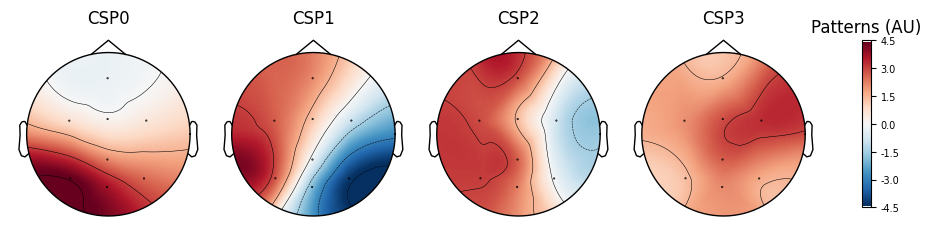

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, StratifiedKFold

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, X_trainval, y_trainval, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(y_trainval == "relax")
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

clf.fit(X, y)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(X, y)
csp.plot_patterns(processor.raw.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
plt.show()

In [22]:
# Load the second recording and validate on that
recording_path = '../recordings/recording_relax4.raw.fif'
processor = BCIDataProcessor(recording_path, l_freq=10, h_freq=20, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process()
# Only select relax/focus
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[ 1.59079459e-10, -7.80371696e-06, -1.40883877e-05, ...,
           3.72836995e-06,  2.54364284e-06,  1.09447261e-06],
         [ 8.88147311e-10, -7.58481445e-06, -1.38241053e-05, ...,
           2.86528464e-06,  1.74804882e-06,  2.15820157e-07],
         [ 4.63451094e-10, -3.90132916e-06, -7.15632077e-06, ...,
           2.54138237e-07,  1.36556015e-07,  2.43625296e-07],
         ...,
         [ 1.25156049e-09, -8.22888294e-06, -1.49232436e-05, ...,
           3.94018412e-06,  2.49964487e-06,  3.69097852e-07],
         [ 1.52764718e-09, -4.41608780e-06, -7.99126228e-06, ...,
          -4.86581231e-06, -6.22799421e-06, -6.98624768e-06],
         [-1.29836580e-10, -3.24876517e-06, -5.92592313e-06, ...,
          -6.09108017e-06, -6.64295291e-06, -6.40734743e-06]],
 
        [[-3.73954155e-07, -1.62399257e-06, -2.45208486e-06, ...,
           1.90450535e-06,  1.98997544e-06,  1.37966978e-06],
         [-1.44957291e-06, -2.92715813e-06, -3.91364199e-06, ...,
          -2

In [23]:
# Prepare the data for validation
X_val = np.concatenate(list(data.values()), axis=0)
y_val = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)

# Evaluate the trained model on the validation data
val_score = clf.score(X_val, y_val)
print(f"Validation accuracy: {val_score}")

Validation accuracy: 0.8541666666666666


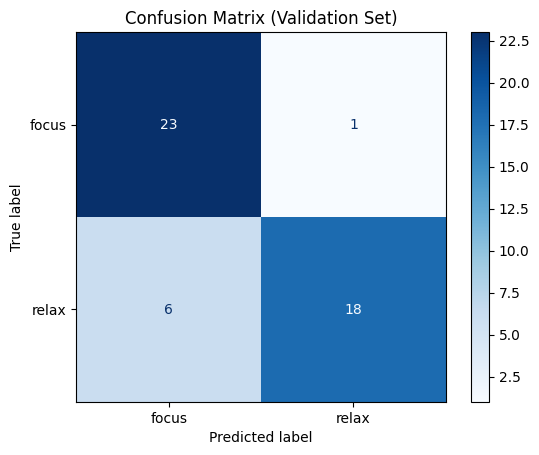

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the validation data
y_val_pred = clf.predict(X_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()